In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
plt.style.use("ggplot")

In [7]:
sub = pd.read_csv("data/shuffled_with_txt.csv", usecols=["LON", "LAT", "country"], nrows=10_000)
sub.head()

,LON,LAT,country
0,10.399753,50.703708,germany
1,-1.070652,41.482844,spain
2,-1.505647,46.630685,france
3,5.442449,43.539935,france
4,7.478071,48.831396,france


In [8]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LON      10000 non-null  float64
 1   LAT      10000 non-null  float64
 2   country  10000 non-null  object 
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


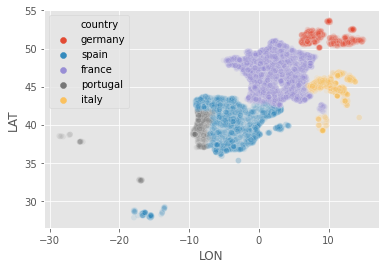

In [9]:
sns.scatterplot(data=sub.query("LAT > 20"), 
                x="LON", y='LAT', hue='country', alpha=0.1) ;

In [11]:
from sklearn.ensemble import RandomForestClassifier as RfSk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def fit_predict_sk(clf, df):
    X = df[['LON', 'LAT']]
    y = LabelEncoder().fit_transform(df["country"])
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

In [12]:
MAX_ROWS = 58373613
all_lengths = np.logspace(3, np.log10(MAX_ROWS), 6)
clf = RfSk(50)
print(all_lengths)

[1.00000000e+03 8.97931723e+03 8.06281379e+04 7.23985628e+05
 6.50089662e+06 5.83736130e+07]


In [16]:
def benchmark_sk(all_lengths):
    all_durations_sk = dict()
    for nrows in all_lengths:
        nrows = int(nrows)
        df = pd.read_csv("data/shuffled_with_txt.csv", nrows=nrows, 
                        usecols=["LAT", "LON", "country"])

        start = time.time()
        y_pred = fit_predict_sk(clf, df)
        end = time.time()

        duration_sk = end - start
        print(nrows, ':', duration_sk / 60)
        all_durations_sk[nrows] = duration_sk
    return all_durations_sk

In [19]:
all_durations_sk = benchmark_sk(all_lengths)

1000 : 0.001755960782368978
8979 : 0.0031783660252888996
80628 : 0.02943800687789917
723985 : 0.7627002914746602
6500896 : 12.672479331493378
58373613 : 147.37156292597453


In [16]:
all_durations_sk = {1000 : 0.001755960782368978,
8979 : 0.0031783660252888996,
80628 : 0.02943800687789917,
723985 : 0.7627002914746602,
6500896 : 12.672479331493378,
58373613 : 147.37156292597453}
all_durations_sk = {k: v * 60 for k, v in all_durations_sk.items()}

In [24]:
def plot_regions(clf, X, h=0.2, cm=plt.cm.RdBu):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

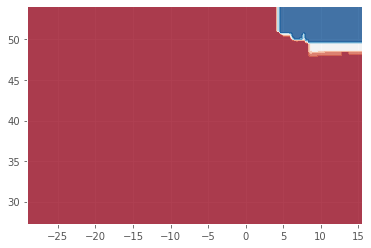

In [25]:
plot_regions(clf, sub.query("LAT > 20")[["LON", "LAT"]].values)

# Spark

In [5]:
!export SPARK_HOME=~/spark-3.0.0-bin-hadoop2.7.tgz

In [2]:
import findspark
findspark.init("/home/horace/spark-3.0.0-bin-hadoop2.7")

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler

def create_pipeline(df):
    label_indexer = StringIndexer(inputCol="country", outputCol="label", handleInvalid="skip").fit(df)
    label_converter = IndexToString(
        inputCol="prediction", 
        outputCol="predictedLabel",
        labels=label_indexer.labels
    )
    assembler = VectorAssembler(
        inputCols=["LON", "LAT"],
        outputCol="features"
    )

    rf = RandomForestClassifier(
        numTrees=50, 
        maxDepth=2, 
        labelCol="label", 
        seed=42
    )

    pipeline = Pipeline(
        stages=
        [
            label_indexer, 
            assembler,
            rf,
            label_converter
        ]
    )
    return pipeline

In [4]:
def fit_predict(pipeline, df):
    model = pipeline.fit(df)
    predictions = model.transform(df)
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='accuracy'
    )
    accuracy = evaluator.evaluate(predictions)
    print("accuracy: ", accuracy)
    return predictions

In [13]:
all_durations_spark = dict()
for nrows in all_lengths:
    nrows = int(nrows)
    df = spark.read.option("header","true").csv("data/shuffled_with_txt.csv").limit(nrows)
    df = df.withColumn("LAT", df["LAT"].cast("double")).withColumn("LON", df["LON"].cast("double"))
    
    pipeline = create_pipeline(df)
    start = time.time()
    predictions = fit_predict(pipeline, df)
    end = time.time()

    duration_spark = end - start
    all_durations_spark[nrows] = duration_spark
    print(nrows, ':', duration_spark / 60)

accuracy:  0.768
1000 : 0.05312294562657674
accuracy:  0.7761443367858336
8979 : 0.031846324602762856
accuracy:  0.7817259512824329
80628 : 0.09205007950464884
accuracy:  0.7667465486163387
723985 : 0.7267998735109965
accuracy:  0.7761736228359906
6500896 : 5.048737303415934
accuracy:  0.7728095320332333
58373613 : 31.127927593390147


In [23]:
spark.stop()

# Comparison plots

In [17]:
plt.style.use('ggplot')

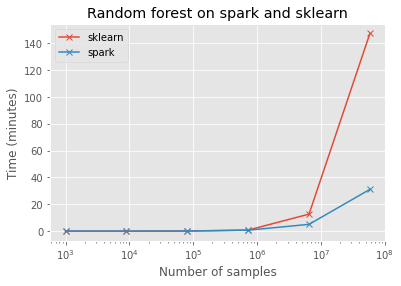

In [18]:
df = pd.DataFrame({'sklearn': all_durations_sk, 
              'spark': all_durations_spark}) / 60

ax = df.plot(marker='x', logx=True)
plt.xlabel("Number of samples")
plt.ylabel("Time (minutes)")
plt.title("Random forest on spark and sklearn")
fig = ax.get_figure()

fig.savefig("benchmark_rf_full.png")

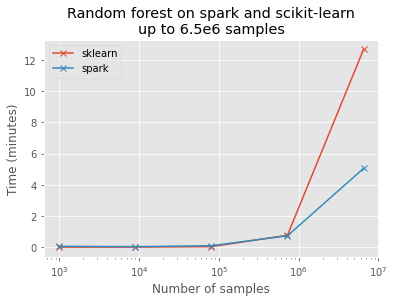

In [19]:
ax = df.iloc[:-1].plot(logx=True, marker='x')

plt.xlabel("Number of samples")
plt.ylabel("Time (minutes)")
plt.title("Random forest on spark and scikit-learn\nup to 6.5e6 samples")
fig = ax.get_figure()

fig.savefig("benchmark_rf_10^7.png")

In [20]:
all_lengths

array([1.00000000e+03, 8.97931723e+03, 8.06281379e+04, 7.23985628e+05,
       6.50089662e+06, 5.83736130e+07])

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

dataset = txt_df
TfidfTransformer()
tfidf = TfidfVectorizer(max_features=5000)
vect = tfidf.fit_transform(txt_df["STREET"].dropna().values)
vect

NameError: name 'txt_df' is not defined

In [ ]:
tfidf.vocabulary_

In [ ]:
txt_df[["STREET"]]